In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import utils
from whitelists import *
from sorted_crates import *
from top_crates import *
import functools

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)

In [2]:
# Load tables
function_definitions = utils.load_selected_function_definitions()
raw_function_unsafe_reasons = utils.load_unsafe_reasons_in_function_definitions()
unsafe_block_calls = utils.load_unsafe_block_calls()
const_calls = utils.load_const_calls()
unsafe_blocks = utils.load_unsafe_blocks()
traits = utils.load_selected_traits()
traits_impls = utils.load_selected_impl_definitions()
type_defs = utils.load_selected_type_defs()
adts = utils.load_selected_adts()
adt_field_types = utils.load_selected_adt_field_types()
selected_builds = utils.load_selected_builds()

In [3]:
# Cleanup: remove duplicates
raw_function_unsafe_reasons = raw_function_unsafe_reasons.drop_duplicates()

# Remove functions that are not in function_definitions
raw_function_unsafe_reasons = raw_function_unsafe_reasons[
    raw_function_unsafe_reasons.def_path.isin(set(function_definitions.def_path.unique()))
]

possible_unsafe_reasons = [
    "call to unsafe function",
    "use of inline assembly",
    "initializing type with `rustc_layout_scalar_valid_range` attr",
    "cast of pointer to int",
    "pointer operation",
    "borrow of packed field",
    "use of mutable static",
    "use of extern static",
    "dereference of raw pointer",
    "assignment to non-`Copy` union field",
    "access to union field",
    "mutation of layout constrained field",
    "borrow of layout constrained field with interior mutability",
]

# Map reasons -> number
function_unsafe_reasons = raw_function_unsafe_reasons[
    ["crate_name", "crate_hash", "def_path", "unsafe_reason"]
].groupby("def_path").agg(frozenset).rename(
    columns={'unsafe_reason': 'unsafe_reasons'}
)

function_unsafe_reasons["unsafe_reasons_vec"] = function_unsafe_reasons.unsafe_reasons.map(
    lambda x: [reason in x for reason in possible_unsafe_reasons]
)
function_unsafe_reasons["num_unsafe_reasons"] = function_unsafe_reasons.unsafe_reasons_vec.map(sum)

for reason in possible_unsafe_reasons:
    function_unsafe_reasons[reason] = function_unsafe_reasons.unsafe_reasons.map(
        lambda x: reason in x
    )

# Augment const calls made from unsafe blocks
unsafe_block_const_calls = unsafe_block_calls.join(
    const_calls.set_index("call"),
    on="call",
    how="inner",
    rsuffix="_defsite",
)
# Rename confusing columns
unsafe_block_const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)
const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)

# Preprocessing
crates = pd.DataFrame({
    "crate": selected_builds.crate,
    "crate_hash": selected_builds.crate_hash,
    "package": selected_builds.package.map(lambda x: str(x).lower().replace("-", "_")),
})
user_written_unsafe_blocks = unsafe_blocks[unsafe_blocks.check_mode == "UnsafeBlockUserProvided"]
unsafe_function_definitions = function_definitions[function_definitions.unsafety == "Unsafe"]
unsafe_traits = traits[traits.unsafety == "Unsafe"]
unsafe_traits_impls = traits_impls[traits_impls.unsafety == "Unsafe"]

In [4]:
# Whitelists
all_function_names = set(function_definitions.def_path.unique())
unchecked_function_names = get_unchecked_function_names(all_function_names)
unguarded_function_names = get_unguarded_function_names(all_function_names)

In [5]:
# Calls
all_calls = utils.load_all_calls()
unsafe_calls = all_calls.query("unsafety != 'Normal'")
assert len(pd.unique(unsafe_calls.unsafety)) == 1

In [6]:
### Filter by user-written unsafe code
user_written_unsafe_const_calls = const_calls[
    const_calls.check_mode == "UnsafeBlockUserProvided"
]

slice_call = []
for x in user_written_unsafe_const_calls.def_path.unique():
    if x.endswith('slice::raw::from_raw_parts'):
        slice_call.append(x)
        break

parts = slice_call[0].split("[")
core_hash = parts[1].split("]")[0]
core_hash

'9e99'

In [7]:
# Top X Crates
def norm(x):
    return x.lower().replace("-", "_")

top_250_compiling_crates = set(map(norm, sorted_crates[:250])) & set(map(norm, selected_builds.package.unique()))
top_250_crates_set = set(sorted_crates[:250])
top_250_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_250_crates_set)
top_250_builds = selected_builds[top_250_mask][
    ~selected_builds[top_250_mask]["package"].duplicated()
]
top_500_compiling_crates = set(map(norm, sorted_crates[:500])) & set(map(norm, selected_builds.package.unique()))
top_500_crates_set = set(sorted_crates[:500])
top_500_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_500_crates_set)
top_500_builds = selected_builds[top_500_mask][
    ~selected_builds[top_500_mask]["package"].duplicated()
]
top_1000_compiling_crates = set(map(norm, sorted_crates[:1000])) & set(map(norm, selected_builds.package.unique()))
top_1000_crates_set = set(sorted_crates[:1000])
top_1000_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_1000_crates_set)
top_1000_builds = selected_builds[top_1000_mask][
    ~selected_builds[top_1000_mask]["package"].duplicated()
]

In [8]:
print("Number of compiling crates in top 250:\t", len(top_250_compiling_crates))
print("Number of builds in top 250:\t\t", len(top_250_builds))
print("Number of expected crates in top 250:\t", len(sorted_crates[:250]))

Number of compiling crates in top 250:	 4
Number of builds in top 250:		 4
Number of expected crates in top 250:	 250


In [9]:
print("Number of compiling crates in top 500:\t", len(top_500_compiling_crates))
print("Number of builds in top 500:\t\t", len(top_500_builds))
print("Number of expected crates in top 500:\t", len(sorted_crates[:500]))

Number of compiling crates in top 500:	 6
Number of builds in top 500:		 6
Number of expected crates in top 500:	 500


In [10]:
print("Number of compiling crates in top 1000:\t", len(top_1000_compiling_crates))
print("Number of builds in top 1000:\t\t", len(top_1000_builds))
print("Number of expected crates in top 1000:\t", len(sorted_crates[:1000]))

Number of compiling crates in top 1000:	 12
Number of builds in top 1000:		 12
Number of expected crates in top 1000:	 1000


In [11]:
print("Number of selected builds:\t", len(selected_builds))
print("Number of crates total:\t\t", len(crates))

Number of selected builds:	 142
Number of crates total:		 142


------top 250------
Rust    13
Name: abi, dtype: int64

Percents:
Rust    100.0
Name: abi, dtype: float64

Unsafe function definitions: 13


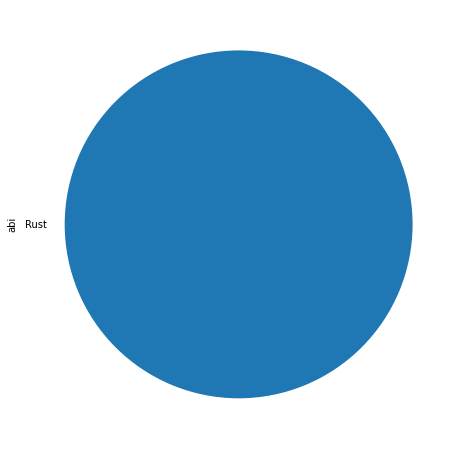

In [35]:
# Frequency of abi DEFINITIONS
top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(top_250_builds.crate) #sorted_crates[:250])
]
values = top_unsafe_defs.abi.value_counts()

print("------top 250------")
print(values)
print()
print("Percents:")
print(values / len(top_unsafe_defs) * 100)
print()
print("Unsafe function definitions:", len(top_unsafe_defs))
values.plot.pie()

del values, top_unsafe_defs

------top 500------
Rust    13
Name: abi, dtype: int64

Percents:
Rust    100.0
Name: abi, dtype: float64

Unsafe function definitions: 13


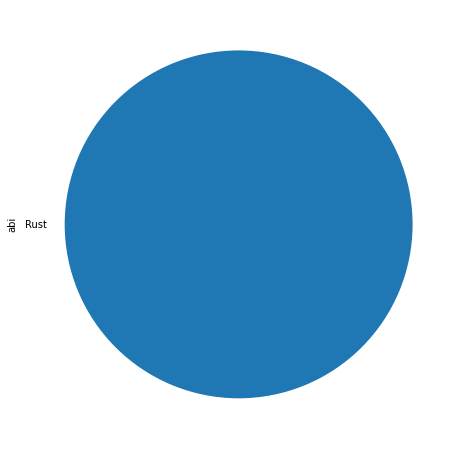

In [36]:
# Frequency of abi DEFINITIONS
top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(top_500_builds.crate)
]
values = top_unsafe_defs.abi.value_counts()

print("------top 500------")
print(values)
print()
print("Percents:")
print(values / len(top_unsafe_defs) * 100)
print()
print("Unsafe function definitions:", len(top_unsafe_defs))
values.plot.pie()

del values, top_unsafe_defs

------top 1000------
Rust    68
C        1
Name: abi, dtype: int64

Percents:
Rust    98.550725
C        1.449275
Name: abi, dtype: float64

Unsafe function definitions: 69


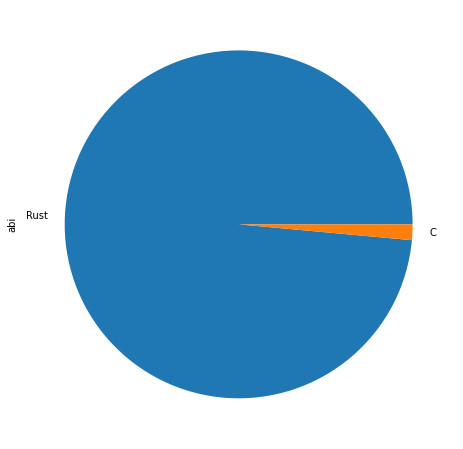

In [37]:
# Frequency of abi DEFINITIONS
top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(top_1000_builds.crate)
]
values = top_unsafe_defs.abi.value_counts()

print("------top 1000------")
print(values)
print()
print("Percents:")
print(values / len(top_unsafe_defs) * 100)
print()
print("Unsafe function definitions:", len(top_unsafe_defs))
values.plot.pie()

del values, top_unsafe_defs

------total------
Rust           360
ForeignItem     39
C                1
Name: abi, dtype: int64

Percents:
Rust           90.00
ForeignItem     9.75
C               0.25
Name: abi, dtype: float64

Unsafe function definitions: 400


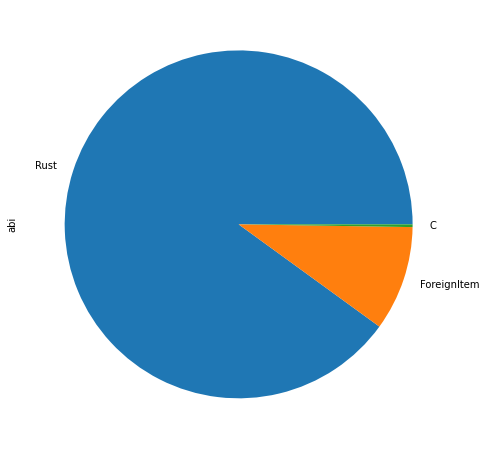

In [15]:
# Frequency of abi DEFINITIONS

values = unsafe_function_definitions.abi.value_counts()

print("------total------")
print(values)
print()
print("Percents:")
print(values / len(unsafe_function_definitions) * 100)
print()
print("Unsafe function definitions:", len(unsafe_function_definitions))
values.plot.pie()

del values

In [39]:
# Which crates define unsafe Rust functions?
def_unsafe_rust_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "Rust"
]

print("------top 250------")
def_urust = def_unsafe_rust_funcs[
    def_unsafe_rust_funcs.crate.isin(top_250_builds.crate)
]
values = def_urust.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Top 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values, def_urust

print("------top 500------")
def_urust = def_unsafe_rust_funcs[
    def_unsafe_rust_funcs.crate.isin(top_500_builds.crate)
]
values = def_urust.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Top 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values, def_urust

print("------top 1000------")
def_urust = def_unsafe_rust_funcs[
    def_unsafe_rust_funcs.crate.isin(top_1000_builds.crate)
]
values = def_urust.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Top 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values, def_urust

print("------total------")
values = def_unsafe_rust_funcs.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Top 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values

------top 250------
Number of crates that define unsafe Rust functions:	 2
Top 20 crates with most defined unsafe Rust functions:

arrayvec     9
crc32fast    4
Name: crate, dtype: int64
------top 500------
Number of crates that define unsafe Rust functions:	 2
Top 20 crates with most defined unsafe Rust functions:

arrayvec     9
crc32fast    4
Name: crate, dtype: int64
------top 1000------
Number of crates that define unsafe Rust functions:	 5
Top 20 crates with most defined unsafe Rust functions:

matrixmultiply    35
rusqlite          15
arrayvec           9
tonic              5
crc32fast          4
Name: crate, dtype: int64
------total------
Number of crates that define unsafe Rust functions:	 20
Top 20 crates with most defined unsafe Rust functions:

bevy_hecs          154
hecs                73
matrixmultiply      35
itoap               23
rusqlite            15
arrayvec             9
lebe                 8
gkquad               6
sprs                 5
tonic                5
lis

In [41]:
# Which crates define C functions?
def_c_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "C"
]
values = def_c_funcs.crate.value_counts()

print("------top 250------")
def_c = def_c_funcs[
    def_c_funcs.crate.isin(top_250_builds.crate)
]
vals = def_c.crate.value_counts()
print("Number of crates that define C functions:\t", len(vals))
print("Top 20 crates with most defined C functions:")
print()
print(vals[:20])
print()
del vals, def_c

print("------top 500------")
def_c = def_c_funcs[
    def_c_funcs.crate.isin(top_500_builds.crate)
]
vals = def_c.crate.value_counts()
print("Number of crates that define C functions:\t", len(vals))
print("Top 20 crates with most defined C functions:")
print()
print(vals[:20])
print()
del vals, def_c

print("------top 1000------")
def_c = def_c_funcs[
    def_c_funcs.crate.isin(top_1000_builds.crate)
]
vals = def_c.crate.value_counts()
print("Number of crates that define C functions:\t", len(vals))
print("Top 20 crates with most defined C functions:")
print()
print(vals[:20])
print()
del vals, def_c

print("------total------")
print("Number of crates that define C functions:\t", len(values))
print("Top 20 crates with most defined C functions:")
print()
print(values[:20])
del values

------top 250------
Number of crates that define C functions:	 0
Top 20 crates with most defined C functions:

Series([], Name: crate, dtype: int64)

------top 500------
Number of crates that define C functions:	 0
Top 20 crates with most defined C functions:

Series([], Name: crate, dtype: int64)

------top 1000------
Number of crates that define C functions:	 1
Top 20 crates with most defined C functions:

rusqlite    1
Name: crate, dtype: int64

------total------
Number of crates that define C functions:	 1
Top 20 crates with most defined C functions:

rusqlite    1
Name: crate, dtype: int64


In [42]:
# Which crates define Foreign Items?
def_fi_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "ForeignItem"
]
values = def_fi_funcs.crate.value_counts()

print("------top 250------")
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(top_250_builds.crate)
]
vals = def_fi.crate.value_counts()
print("Number of crates that define Foreign Items:\t", len(vals))
print("Top 20 crates with most defined Foreign Items:")
print()
print(vals[:20])
print()
del vals, def_fi

print("------top 500------")
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(top_500_builds.crate)
]
vals = def_fi.crate.value_counts()
print("Number of crates that define Foreign Items:\t", len(vals))
print("Top 20 crates with most defined Foreign Items:")
print()
print(vals[:20])
print()
del vals, def_fi

print("------top 1000------")
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(top_1000_builds.crate)
]
vals = def_fi.crate.value_counts()
print("Number of crates that define Foreign Items:\t", len(vals))
print("Top 20 crates with most defined Foreign Items:")
print()
print(vals[:20])
print()
del vals, def_fi

print("------total------")
print("Number of crates that define Foreign Items:\t", len(values))
print("Top 20 crates with most defined Foreign Items:")
print()
print(values[:20])
# crypto sneaks in here again
del values

------top 250------
Number of crates that define Foreign Items:	 0
Top 20 crates with most defined Foreign Items:

Series([], Name: crate, dtype: int64)

------top 500------
Number of crates that define Foreign Items:	 0
Top 20 crates with most defined Foreign Items:

Series([], Name: crate, dtype: int64)

------top 1000------
Number of crates that define Foreign Items:	 0
Top 20 crates with most defined Foreign Items:

Series([], Name: crate, dtype: int64)

------total------
Number of crates that define Foreign Items:	 2
Top 20 crates with most defined Foreign Items:

sds         21
listpack    18
Name: crate, dtype: int64


------top 250------
Rust              55
rust-intrinsic    10
Name: abi, dtype: int64

Percents: 
Rust              84.615385
rust-intrinsic    15.384615
Name: abi, dtype: float64

Unsafe calls: 65


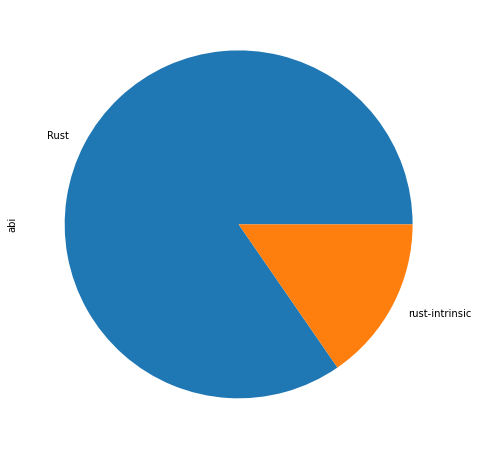

In [43]:
# Frequency of abi CALLS
unsafe_const_calls = const_calls[
    const_calls.unsafety == "Unsafe"
]
unsafe_const_calls_250 = unsafe_const_calls[
    unsafe_const_calls.crate_callsite.isin(top_250_builds.crate)
]
values_250 = unsafe_const_calls_250.abi.value_counts()

print("------top 250------")
print(values_250)
print()
print("Percents: ")
print(values_250 / len(unsafe_const_calls_250) * 100)
print()
print("Unsafe calls:", len(unsafe_const_calls_250))
values_250.plot.pie()

del values_250

------top 500------
Rust              55
rust-intrinsic    10
Name: abi, dtype: int64

Percents: 
Rust              84.615385
rust-intrinsic    15.384615
Name: abi, dtype: float64

Unsafe calls: 65


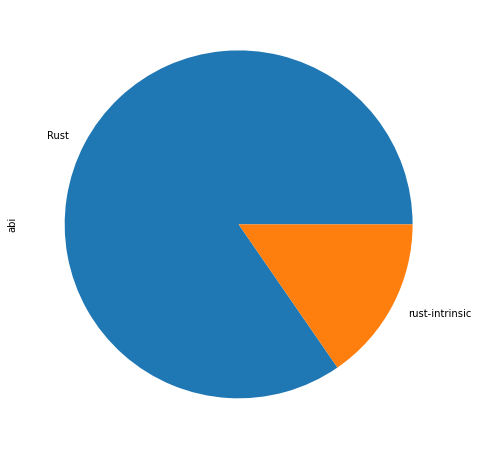

In [44]:
unsafe_const_calls_500 = unsafe_const_calls[
    unsafe_const_calls.crate_callsite.isin(top_500_builds.crate)
]
values_500 = unsafe_const_calls_500.abi.value_counts()

print("------top 500------")
print(values_500)
print()
print("Percents: ")
print(values_500 / len(unsafe_const_calls_500) * 100)
print()
print("Unsafe calls:", len(unsafe_const_calls_500))
values_500.plot.pie()

del values_500

------top 1000------
Rust              177
C                  49
rust-intrinsic     22
Name: abi, dtype: int64

Percents: 
Rust              71.370968
C                 19.758065
rust-intrinsic     8.870968
Name: abi, dtype: float64

Unsafe calls: 248


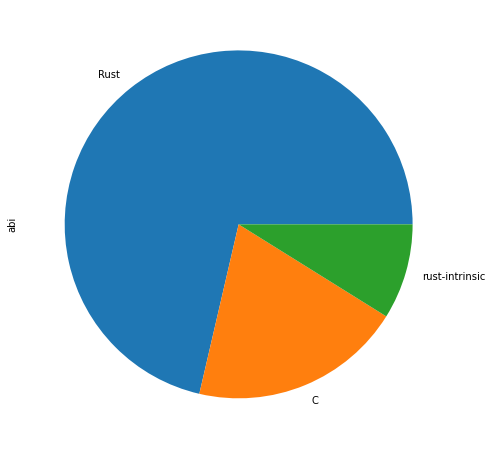

In [45]:
unsafe_const_calls_1000 = unsafe_const_calls[
    unsafe_const_calls.crate_callsite.isin(top_1000_builds.crate)
]
values_1000 = unsafe_const_calls_1000.abi.value_counts()

print("------top 1000------")
print(values_1000)
print()
print("Percents: ")
print(values_1000 / len(unsafe_const_calls_1000) * 100)
print()
print("Unsafe calls:", len(unsafe_const_calls_1000))
values_1000.plot.pie()

del values_1000

------total------
Rust              978
rust-intrinsic    219
C                 114
Name: abi, dtype: int64

Percents: 
Rust              74.599542
rust-intrinsic    16.704805
C                  8.695652
Name: abi, dtype: float64

Unsafe calls: 1311


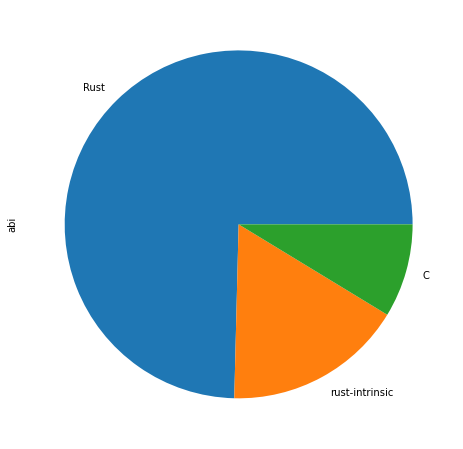

In [22]:
# Frequency of abi CALLS
values = unsafe_const_calls.abi.value_counts()

print("------total------")
print(values)
print()
print("Percents: ")
print(values / len(unsafe_const_calls) * 100)
print()
print("Unsafe calls:", len(unsafe_const_calls))
values.plot.pie()

del values

In [46]:
# Which crates call unsafe Rust functions? - ALL
calls_unsafe_rust_funcs = unsafe_const_calls[
    unsafe_const_calls.abi == "Rust"
]
#values = calls_unsafe_rust_funcs[['crate_callsite', 'package_version']].apply(
#    lambda row: (row['crate_callsite'], row['package_version']), axis=1
#).squeeze().value_counts()

# Filter by user-written blocks
uw_calls_unsafe_rust_funcs = calls_unsafe_rust_funcs[
    calls_unsafe_rust_funcs.check_mode == "UnsafeBlockUserProvided"
]
values_uw = uw_calls_unsafe_rust_funcs[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()

#print(len(values))
#print(len(values_uw))
#print()
#assert(len(values) == len(values_uw))
#del values

print("------top 250------")
uw_urust = uw_calls_unsafe_rust_funcs[
    uw_calls_unsafe_rust_funcs.crate_callsite.isin(top_250_builds.crate)
]
values = uw_urust[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call unsafe Rust:\t", len(values))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values[:20])
print()
del values

print("------top 500------")
uw_urust = uw_calls_unsafe_rust_funcs[
    uw_calls_unsafe_rust_funcs.crate_callsite.isin(top_500_builds.crate)
]
values = uw_urust[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call unsafe Rust:\t", len(values))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values[:20])
print()
del values

print("------top 1000------")
uw_urust = uw_calls_unsafe_rust_funcs[
    uw_calls_unsafe_rust_funcs.crate_callsite.isin(top_1000_builds.crate)
]
values = uw_urust[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call unsafe Rust:\t", len(values))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values[:20])
print()
del values

print("------total------")
print("Number of crates that call unsafe Rust:\t", len(values_uw))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values_uw[:20])
del values_uw

------top 250------
Number of crates that call unsafe Rust:	 2
Top 20 crates with most unsafe Rust calls:	

(arrayvec, 0.5.2)     54
(crc32fast, 1.2.1)     1
dtype: int64

------top 500------
Number of crates that call unsafe Rust:	 2
Top 20 crates with most unsafe Rust calls:	

(arrayvec, 0.5.2)     54
(crc32fast, 1.2.1)     1
dtype: int64

------top 1000------
Number of crates that call unsafe Rust:	 6
Top 20 crates with most unsafe Rust calls:	

(arrayvec, 0.5.2)          54
(rusqlite, 0.24.1)         21
(tonic, 0.3.1)             19
(base_x, 0.2.8)             9
(matrixmultiply, 0.2.3)     3
(crc32fast, 1.2.1)          1
dtype: int64

------total------
Number of crates that call unsafe Rust:	 35
Top 20 crates with most unsafe Rust calls:	

(html_escape, 0.2.6)       89
(lebe, 0.5.1)              84
(rudy, 0.1.0)              67
(ropey, 1.2.0)             59
(bevy_hecs, 0.3.0)         58
(arrayvec, 0.5.2)          54
(hecs, 0.3.1)              53
(gkquad, 0.0.4)            40
(bdb, 

In [47]:
# Which crates call C functions?
calls_c_funcs = unsafe_const_calls[
    unsafe_const_calls.abi == "C"
]

print("------top 250------")
calls_c = calls_c_funcs[
    calls_c_funcs.crate_callsite.isin(top_250_builds.crate)
]
values = calls_c[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Top 20 crates with most C calls:")
print()
print(values[:20])
print()
del values

print("------top 500------")
calls_c = calls_c_funcs[
    calls_c_funcs.crate_callsite.isin(top_500_builds.crate)
]
values = calls_c[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Top 20 crates with most C calls:")
print()
print(values[:20])
print()
del values

print("------top 1000------")
calls_c = calls_c_funcs[
    calls_c_funcs.crate_callsite.isin(top_1000_builds.crate)
]
values = calls_c[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Top 20 crates with most C calls:")
print()
print(values[:20])
print()
del values

print("------total------")
values = calls_c_funcs[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Top 20 crates with most C calls:")
print()
print(values[:20])
del values

------top 250------
Number of crates that call C functions:	 0
Top 20 crates with most C calls:

Series([], dtype: int64)

------top 500------
Number of crates that call C functions:	 0
Top 20 crates with most C calls:

Series([], dtype: int64)

------top 1000------
Number of crates that call C functions:	 1
Top 20 crates with most C calls:

(rusqlite, 0.24.1)    49
dtype: int64

------total------
Number of crates that call C functions:	 5
Top 20 crates with most C calls:

(rusqlite, 0.24.1)      49
(sds, 0.1.0)            27
(listpack, 0.1.6)       23
(quinn, 0.6.1)          12
(mprober_lib, 0.1.4)     3
dtype: int64


In [48]:
# SIMD const calls
simd_functions = set([
    x
    for x in const_calls.def_path.unique()
    if x.startswith('core[' + core_hash + ']::core_arch')
])
simd_calls = const_calls[
    const_calls.def_path.isin(simd_functions)
]

print("------top 250------")
top_simd = simd_calls[
    simd_calls.crate_callsite.isin(top_250_builds.crate)
]
simd_crates = top_simd[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of SIMD calls:\t\t\t", len(top_simd))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
print()
del top_simd, simd_crates

print("------top 500------")
top_simd = simd_calls[
    simd_calls.crate_callsite.isin(top_500_builds.crate)
]
simd_crates = top_simd[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of SIMD calls:\t\t\t", len(top_simd))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
print()
del top_simd, simd_crates

print("------top 1000------")
top_simd = simd_calls[
    simd_calls.crate_callsite.isin(top_1000_builds.crate)
]
simd_crates = top_simd[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of SIMD calls:\t\t\t", len(top_simd))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
print()
del top_simd, simd_crates

print("------total------")
simd_crates = simd_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of SIMD calls:\t\t\t", len(simd_calls))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
del simd_crates

------top 250------
Number of SIMD calls:			 0
Number of crates that call SIMD:	 0
Crates that call SIMD functions:
Series([], dtype: int64)

------top 500------
Number of SIMD calls:			 0
Number of crates that call SIMD:	 0
Crates that call SIMD functions:
Series([], dtype: int64)

------top 1000------
Number of SIMD calls:			 0
Number of crates that call SIMD:	 0
Crates that call SIMD functions:
Series([], dtype: int64)

------total------
Number of SIMD calls:			 18
Number of crates that call SIMD:	 1
Crates that call SIMD functions:
(ropey, 1.2.0)    18
dtype: int64


In [27]:
# Count functions with assembly code, per crate
asm_fns = function_unsafe_reasons[function_unsafe_reasons["use of inline assembly"]]
print("Number of functions using inline assembly:\t", len(asm_fns))
if len(asm_fns) > 0:
    values = asm_fns[['crate_name', 'crate_hash']].apply(
        lambda row: (row['crate_name'], row['crate_hash']), axis=1
    ).squeeze().value_counts()
    print("Number of crates:", len(values))
    print()
    print('Percentage of functions with inline assembly among 10 top crates:', sum(values[:10])/len(asm_fns)*100)
    print("Such functions per crate:")
    print(values[:10])
    asm_fns
    del values

Number of functions using inline assembly:	 0


In [51]:
# Unchecked functions
const_unchecked_calls = const_calls[
    const_calls.def_path.isin(unchecked_function_names)
]
unchecked_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unchecked_function_names)
]
assert(len(const_unchecked_calls) == len(unchecked_calls))
del const_unchecked_calls

print("------top 250------")
def filter_func(x):
    if x.split("[")[0] in top_250_builds.crate:
        return True
    else:
        return False

names = filter(filter_func, unchecked_function_names)
count = 0
for n in names:
    count+=1

top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(top_250_builds.crate)
]
values = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("unchecked_function_names:\t", count)
print("Calls to unchecked functions:\t", len(top_unchecked))
print("Percentage:\t\t\t", len(top_unchecked)/len(unsafe_calls)*100)
print()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(top_250_builds)*100)
print(values)
print()
del values, names, count, top_unchecked, filter_func

print("------top 500------")
def filter_func(x):
    if x.split("[")[0] in top_500_builds.crate:
        return True
    else:
        return False

names = filter(filter_func, unchecked_function_names)
count = 0
for n in names:
    count+=1

top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(top_500_builds.crate)
]
values = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("unchecked_function_names:\t", count)
print("Calls to unchecked functions:\t", len(top_unchecked))
print("Percentage:\t\t\t", len(top_unchecked)/len(unsafe_calls)*100)
print()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(top_500_builds)*100)
print(values)
print()
del values, names, count, top_unchecked, filter_func

print("------top 1000------")
def filter_func(x):
    if x.split("[")[0] in top_1000_builds.crate:
        return True
    else:
        return False

names = filter(filter_func, unchecked_function_names)
count = 0
for n in names:
    count+=1

top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(top_1000_builds.crate)
]
values = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("unchecked_function_names:\t", count)
print("Calls to unchecked functions:\t", len(top_unchecked))
print("Percentage:\t\t\t", len(top_unchecked)/len(unsafe_calls)*100)
print()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(top_1000_builds)*100)
print(values)
print()
del values, names, count, top_unchecked, filter_func

print("------total------")
values = unchecked_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("unchecked_function_names:\t", len(unchecked_function_names))
print("Calls to unchecked functions:\t", len(unchecked_calls))
print("Percentage:\t\t\t", len(unchecked_calls)/len(unsafe_calls)*100)
print()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(selected_builds)*100)
print(values)
del values

------top 250------
unchecked_function_names:	 0
Calls to unchecked functions:	 6
Percentage:			 0.0039092786729302

Number of crates:		 1
Percentage:			 25.0
(arrayvec, 0.5.2)    6
dtype: int64

------top 500------
unchecked_function_names:	 0
Calls to unchecked functions:	 6
Percentage:			 0.0039092786729302

Number of crates:		 1
Percentage:			 16.666666666666664
(arrayvec, 0.5.2)    6
dtype: int64

------top 1000------
unchecked_function_names:	 0
Calls to unchecked functions:	 6
Percentage:			 0.0039092786729302

Number of crates:		 1
Percentage:			 8.333333333333332
(arrayvec, 0.5.2)    6
dtype: int64

------total------
unchecked_function_names:	 52
Calls to unchecked functions:	 18
Percentage:			 0.0117278360187906

Number of crates:		 3
Percentage:			 2.112676056338028
(bevy_hecs, 0.3.0)    7
(arrayvec, 0.5.2)     6
(gkquad, 0.0.4)       5
dtype: int64


In [52]:
# Unguarded functions
print("unguarded_function_names:\t", len(unguarded_function_names))
print(unguarded_function_names)

const_unguarded_calls = const_calls[
    const_calls.def_path.isin(unguarded_function_names)
]
unguarded_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unguarded_function_names)
]
assert(len(const_unguarded_calls) == len(unguarded_calls))

print(unguarded_calls)
print("Calls to unguarded functions:\t", len(unguarded_calls))
print("Percentage:\t\t\t", len(unguarded_calls)/len(unsafe_calls)*100)

#values = unguarded_calls[['crate_callsite', 'build_crate_hash']].apply(
#    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
#).squeeze().value_counts()
#print("Number of crates:\t\t", len(values))
#print("Percentage:\t\t\t", len(values)/len(selected_builds)*100)
#print(values[:5])

#print("Percentage of unsafe blocks with an unguarded function call:\t",
#     len(unguarded_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
#)
#del values

unguarded_function_names:	 0
set()
Empty DataFrame
Columns: [build, package_name, package_version, crate_callsite, build_crate_hash, edition, block, unsafe_scope, check_mode, call, unsafety, abi, build_defsite, package_name_defsite, package_version_defsite, crate_name_defsite, build_crate_hash_defsite, edition_defsite, crate_defsite, crate_hash, def_path, def_path_hash, summary_key, block_defsite, unsafe_scope_defsite, check_mode_defsite, unsafety_defsite, abi_defsite]
Index: []
Calls to unguarded functions:	 0
Percentage:			 0.0


In [80]:
# Filter by target language
user_written_unsafe_const_calls_rust = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "Rust"
]
user_written_unsafe_const_calls_intrinsic = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "rust-intrinsic"
]
user_written_unsafe_const_calls_fi = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "ForeignItem"
]
user_written_unsafe_const_calls_c = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "C"
]

In [132]:
# Filter for get_unchecked calls
unchecked = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::get_unchecked'))
        or (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::get_unchecked_mut'))
])

unchecked_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(unchecked)
]

print("------top 250------")
top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(top_250_builds.crate)
]
cleaned_unchecked_calls = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print("Percentage:\t\t", len(cleaned_unchecked_calls)/len(top_250_builds)*100)
print()
for k,v in cleaned_unchecked_calls.iteritems():
    print(k, v)
print()
del cleaned_unchecked_calls, top_unchecked

print("------top 500------")
top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(top_500_builds.crate)
]
cleaned_unchecked_calls = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print("Percentage:\t\t", len(cleaned_unchecked_calls)/len(top_500_builds)*100)
print()
for k,v in cleaned_unchecked_calls.iteritems():
    print(k, v)
print()
del cleaned_unchecked_calls, top_unchecked

print("------top 1000------")
top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(top_1000_builds.crate)
]
cleaned_unchecked_calls = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print("Percentage:\t\t", len(cleaned_unchecked_calls)/len(top_1000_builds)*100)
print()
for k,v in cleaned_unchecked_calls.iteritems():
    print(k, v)
print()
del cleaned_unchecked_calls, top_unchecked

print("------total------")
cleaned_unchecked_calls = unchecked_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print("Percentage:\t\t", len(cleaned_unchecked_calls)/len(selected_builds)*100)
print()
for k,v in cleaned_unchecked_calls.iteritems():
    print(k, v) # crypto again
del cleaned_unchecked_calls

#for x in user_written_unsafe_const_calls_rust.def_path.unique():
#    if 'unchecked' in x:
#        print(x)

------top 250------
Number of crates that use get_unchecked[_mut]:	 0
Percentage:		 0.0


------top 500------
Number of crates that use get_unchecked[_mut]:	 0
Percentage:		 0.0


------top 1000------


AttributeError: 'tuple' object has no attribute 'value_counts'

In [79]:
#print(len(unsafe_block_const_calls.crate_callsite.value_counts()))
#print(len(user_written_unsafe_const_calls_rust.crate_callsite.value_counts()))
#user_written_unsafe_const_calls_rust.crate_callsite.value_counts()
for s in unsafe_block_const_calls.crate_callsite.unique(): 
    if not s in user_written_unsafe_const_calls_rust.crate_callsite.unique(): 
        print(s)

jmespatch
url
tessellation
rumq_core
asap
whatlang
slog_extlog
rex_regex
n5
exr
shakmaty_syzygy
juniper
svgdom
svgparser
ucglib
gb_io


In [116]:
# Copies only
copies = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if x.startswith('core[' + core_hash + ']::intrinsics::copy')
        or x.startswith('core[' + core_hash + ']::intrinsics::copy_nonoverlapping')
])

copy_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(copies)
]

# Filter for perf-mot functions within Rust
perf_mot_unsafe_rust = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if x.startswith('core[' + core_hash + ']::core_arch')
        or x.startswith('core[' + core_hash + ']::intrinsics::write_bytes')
        or x.startswith('core[' + core_hash + ']::intrinsics::copy')
        or x.startswith('core[' + core_hash + ']::intrinsics::copy_nonoverlapping')
        or x.startswith('core[' + core_hash + ']::mem::transmute_copy')
        or x.startswith('core[' + core_hash + ']::slice::raw::from_raw_parts')
        or x.startswith('core[' + core_hash + ']::slice::raw::from_raw_parts_mut')
        or (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::as_ptr'))
        or (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::as_mut_ptr'))
        or ("unchecked" in x)
        or ("unguarded" in x)
])

# Performance-motivated Rust calls
perf_mot_unsafe_rust_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(perf_mot_unsafe_rust)
]

# Rust INTRINSIC Calls
perf_mot_unsafe_intrinsics = set([
    x
    for x in user_written_unsafe_const_calls_intrinsic.def_path.unique()
    if (x.startswith('core[' + core_hash + ']::intrinsics::') and x.endswith('::transmute')) # FIXME DNE anymore?
])

# Performance-motivated Rust intrinsic calls
perf_mot_unsafe_intrinsic_calls = user_written_unsafe_const_calls_intrinsic[
    user_written_unsafe_const_calls_intrinsic.def_path.isin(perf_mot_unsafe_intrinsics)
]

both = [perf_mot_unsafe_rust_calls, perf_mot_unsafe_intrinsic_calls]
perf_mot_unsafe_allrust_calls = pd.concat(both)

#user_written_unsafe_const_calls_intrinsic.def_path.unique()
#for x in user_written_unsafe_const_calls_rust.def_path.unique():
#    if 'core' in x and 'slice' in x:
#        print(x)

In [133]:
# PMU CALLS

print("------top 250------")

top_uw_unsafe_const_calls = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.crate_callsite.isin(top_250_builds.crate)
]
top_pmu_rust_calls = perf_mot_unsafe_allrust_calls[
    perf_mot_unsafe_allrust_calls.crate_callsite.isin(top_250_builds.crate)
]
top_fi_calls = user_written_unsafe_const_calls_fi[
    user_written_unsafe_const_calls_fi.crate_callsite.isin(top_250_builds.crate)
]
top_c_calls = user_written_unsafe_const_calls_c[
    user_written_unsafe_const_calls_c.crate_callsite.isin(top_250_builds.crate)
]

top_copy_calls = copy_calls[
    copy_calls.crate_callsite.isin(top_250_builds.crate)
]
crates_w_copy_calls = top_copy_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
print("Number of crates w copy calls:\t", len(crates_w_copy_calls.value_counts()))
print("Percentage:\t\t", len(crates_w_copy_calls.value_counts())/len(top_250_builds)*100)
print()

pmu_rust_calls = top_pmu_rust_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
fi_calls = top_fi_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
c_calls = top_c_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)

len_all = len(top_pmu_rust_calls) + len(top_fi_calls) + len(top_c_calls)
block_frames = [pmu_rust_calls, fi_calls, c_calls]
block_values = pd.concat(block_frames)[0].value_counts()

print("Total number of (user-written) PMU Rust calls:\t", len(top_pmu_rust_calls))
print("Percent out of unsafe const calls:\t\t", len(top_pmu_rust_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(pmu_rust_calls.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls.value_counts())/len(top_250_builds)*100)
print()
print("Total number of ForeignItem calls:\t", len(top_fi_calls))
print("Percent out of unsafe const calls:\t", len(top_fi_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(fi_calls.value_counts()))
print("Percentage:\t\t", len(fi_calls.value_counts())/len(top_250_builds)*100)
print()
print("Total number of C calls:\t\t", len(top_c_calls))
print("Percent out of unsafe const calls:\t", len(top_c_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(c_calls.value_counts()))
print("Percentage:\t\t", len(c_calls.value_counts())/len(top_250_builds)*100)
print()
print("Total number of (user-written) PMU calls:\t\t", len_all)
print("Out of total number user-written unsafe const calls:\t", len(top_uw_unsafe_const_calls))
print("Percent user-written PMU out of const calls:\t\t", len_all/len(top_uw_unsafe_const_calls)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_250_builds)*100)

del len_all, block_frames, block_values
del top_uw_unsafe_const_calls, top_pmu_rust_calls, top_fi_calls, top_c_calls

# PMU DEFINITIONS (excluding Rust b/c would have to do more in depth analysis of function bodies)

print()
print()
print("------top 250 non-Rust PMU defs------")
print()

top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(top_250_builds.crate)
]
def_c = def_c_funcs[
    def_c_funcs.crate.isin(top_250_builds.crate)
]
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(top_250_builds.crate)
]

len_all = len(def_c) + len(def_fi)
block_frames = [def_c, def_fi]
block_values = pd.concat(block_frames).crate.value_counts()

all_f = [c_calls, def_c, def_fi]
all_vals = pd.concat(all_f).crate.value_counts()

print("Total non-Rust (calls + defs):\t", len(all_vals))
print("Percentage:\t\t", len(all_vals)/len(top_250_builds)*100)
print()
print("Total number of ForeignItem definitions:", len(def_fi))
print("Percent out of unsafe definitions:\t", len(def_fi)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_fi.crate.value_counts()))
print("Percentage:\t\t", len(def_fi.crate.value_counts())/len(top_250_builds)*100)
print()
print("Total number of C definitions:\t\t", len(def_c))
print("Percent out of unsafe definitions:\t", len(def_c)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_c.crate.value_counts()))
print("Percentage:\t\t", len(def_c.crate.value_counts())/len(top_250_builds)*100)
print()
print("Total number of non-Rust PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(top_unsafe_defs))
print("Percent non-Rust PMU out of unsafe definitions:\t", len_all/len(top_unsafe_defs)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_250_builds)*100)

del len_all, block_frames, block_values, top_unsafe_defs

# Total PMU code

print()
print()
print("------top 250 PMU------")
print()

block_frames = [pmu_rust_calls, c_calls, fi_calls, def_c, def_fi] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_250_builds)*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values, pmu_rust_calls, fi_calls, c_calls, def_c, def_fi

------top 250------
Number of crates w copy calls:	 1
Percentage:		 25.0

Total number of (user-written) PMU Rust calls:	 19
Percent out of unsafe const calls:		 20.43010752688172
Number of crates:	 1
Percentage:		 25.0

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of (user-written) PMU calls:		 19
Out of total number user-written unsafe const calls:	 93
Percent user-written PMU out of const calls:		 20.43010752688172

Number of crates:	 1
Percentage:		 25.0


------top 250 non-Rust PMU defs------

Total non-Rust (calls + defs):	 0
Percentage:		 0.0

Total number of ForeignItem definitions: 0
Percent out of unsafe definitions:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C definitions:		 0
Percent out of unsafe definitions:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total numb

In [134]:
# PMU CALLS

print()
print("------top 500------")
print()

top_uw_unsafe_const_calls = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.crate_callsite.isin(top_500_builds.crate)
]
top_pmu_rust_calls = perf_mot_unsafe_allrust_calls[
    perf_mot_unsafe_allrust_calls.crate_callsite.isin(top_500_builds.crate)
]
top_fi_calls = user_written_unsafe_const_calls_fi[
    user_written_unsafe_const_calls_fi.crate_callsite.isin(top_500_builds.crate)
]
top_c_calls = user_written_unsafe_const_calls_c[
    user_written_unsafe_const_calls_c.crate_callsite.isin(top_500_builds.crate)
]

top_copy_calls = copy_calls[
    copy_calls.crate_callsite.isin(top_500_builds.crate)
]
crates_w_copy_calls = top_copy_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
print("Number of crates w copy calls:\t", len(crates_w_copy_calls.value_counts()))
print("Percentage:\t\t", len(crates_w_copy_calls.value_counts())/len(top_500_builds)*100)
print()

pmu_rust_calls = top_pmu_rust_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
fi_calls = top_fi_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
c_calls = top_c_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)

len_all = len(top_pmu_rust_calls) + len(top_fi_calls) + len(top_c_calls)
block_frames = [pmu_rust_calls, fi_calls, c_calls]
block_values = pd.concat(block_frames)[0].value_counts()

print("Total number of (user-written) PMU Rust calls:\t", len(top_pmu_rust_calls))
print("Percent out of unsafe const calls:\t\t", len(top_pmu_rust_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(pmu_rust_calls.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls.value_counts())/len(top_500_builds)*100)
print()
print("Total number of ForeignItem calls:\t", len(top_fi_calls))
print("Percent out of unsafe const calls:\t", len(top_fi_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(fi_calls.value_counts()))
print("Percentage:\t\t", len(fi_calls.value_counts())/len(top_500_builds)*100)
print()
print("Total number of C calls:\t\t", len(top_c_calls))
print("Percent out of unsafe const calls:\t", len(top_c_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(c_calls.value_counts()))
print("Percentage:\t\t", len(c_calls.value_counts())/len(top_500_builds)*100)
print()
print("Total number of (user-written) PMU calls:\t\t", len_all)
print("Out of total number user-written unsafe const calls:\t", len(top_uw_unsafe_const_calls))
print("Percent user-written PMU out of const calls:\t\t", len_all/len(top_uw_unsafe_const_calls)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_500_builds)*100)

del len_all, block_frames, block_values
del top_uw_unsafe_const_calls, top_pmu_rust_calls, top_fi_calls, top_c_calls

# PMU DEFINITIONS (excluding Rust b/c would have to do more in depth analysis of function bodies)

print()
print()
print("------top 500 non-Rust PMU defs------")
print()

top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(top_500_builds.crate)
]
def_c = def_c_funcs[
    def_c_funcs.crate.isin(top_500_builds.crate)
]
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(top_500_builds.crate)
]

len_all = len(def_c) + len(def_fi)
block_frames = [def_c, def_fi]
block_values = pd.concat(block_frames).crate.value_counts()

all_f = [c_calls, def_c, def_fi]
all_vals = pd.concat(all_f).crate.value_counts()

print("Total non-Rust (calls + defs):\t", len(all_vals))
print("Percentage:\t\t", len(all_vals)/len(top_500_builds)*100)
print()
print("Total number of ForeignItem definitions:", len(def_fi))
print("Percent out of unsafe definitions:\t", len(def_fi)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_fi.crate.value_counts()))
print("Percentage:\t\t", len(def_fi.crate.value_counts())/len(top_500_builds)*100)
print()
print("Total number of C definitions:\t\t", len(def_c))
print("Percent out of unsafe definitions:\t", len(def_c)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_c.crate.value_counts()))
print("Percentage:\t\t", len(def_c.crate.value_counts())/len(top_500_builds)*100)
print()
print("Total number of non-Rust PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(top_unsafe_defs))
print("Percent non-Rust PMU out of unsafe definitions:\t", len_all/len(top_unsafe_defs)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_500_builds)*100)

del len_all, block_frames, block_values, top_unsafe_defs

# Total PMU code

print()
print()
print("------top 500 PMU------")
print()

block_frames = [pmu_rust_calls, c_calls, fi_calls, def_c, def_fi] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_500_builds)*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])

del block_frames, block_values, pmu_rust_calls, fi_calls, c_calls, def_c, def_fi


------top 500------

Number of crates w copy calls:	 1
Percentage:		 16.666666666666664

Total number of (user-written) PMU Rust calls:	 19
Percent out of unsafe const calls:		 20.43010752688172
Number of crates:	 1
Percentage:		 16.666666666666664

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of (user-written) PMU calls:		 19
Out of total number user-written unsafe const calls:	 93
Percent user-written PMU out of const calls:		 20.43010752688172

Number of crates:	 1
Percentage:		 16.666666666666664


------top 500 non-Rust PMU defs------

Total non-Rust (calls + defs):	 0
Percentage:		 0.0

Total number of ForeignItem definitions: 0
Percent out of unsafe definitions:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C definitions:		 0
Percent out of unsafe definitions:	 0.0
Number

In [135]:
# PMU CALLS

print()
print("------top 1000 PMU calls------")
print()

top_uw_unsafe_const_calls = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.crate_callsite.isin(top_1000_builds.crate)
]
top_pmu_rust_calls = perf_mot_unsafe_allrust_calls[
    perf_mot_unsafe_allrust_calls.crate_callsite.isin(top_1000_builds.crate)
]
top_fi_calls = user_written_unsafe_const_calls_fi[
    user_written_unsafe_const_calls_fi.crate_callsite.isin(top_1000_builds.crate)
]
top_c_calls = user_written_unsafe_const_calls_c[
    user_written_unsafe_const_calls_c.crate_callsite.isin(top_1000_builds.crate)
]

top_copy_calls = copy_calls[
    copy_calls.crate_callsite.isin(top_1000_builds.crate)
]
crates_w_copy_calls = top_copy_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
print("Number of crates w copy calls:\t", len(crates_w_copy_calls.value_counts()))
print("Percentage:\t\t", len(crates_w_copy_calls.value_counts())/len(top_1000_builds)*100)
print()

pmu_rust_calls = top_pmu_rust_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
fi_calls = top_fi_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
c_calls = top_c_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)

len_all = len(top_pmu_rust_calls) + len(top_fi_calls) + len(top_c_calls)
block_frames = [pmu_rust_calls, fi_calls, c_calls]
block_values = pd.concat(block_frames)[0].value_counts()

print("Total number of (user-written) PMU Rust calls:\t", len(top_pmu_rust_calls))
print("Percent out of unsafe const calls:\t\t", len(top_pmu_rust_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(pmu_rust_calls.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls.value_counts())/len(top_1000_builds)*100)
print()
print("Total number of ForeignItem calls:\t", len(top_fi_calls))
print("Percent out of unsafe const calls:\t", len(top_fi_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(fi_calls.value_counts()))
print("Percentage:\t\t", len(fi_calls.value_counts())/len(top_1000_builds)*100)
print()
print("Total number of C calls:\t\t", len(top_c_calls))
print("Percent out of unsafe const calls:\t", len(top_c_calls)/len(top_uw_unsafe_const_calls)*100)
print("Number of crates:\t", len(c_calls.value_counts()))
print("Percentage:\t\t", len(c_calls.value_counts())/len(top_1000_builds)*100)
print()
print("Total number of (user-written) PMU calls:\t\t", len_all)
print("Out of total number user-written unsafe const calls:\t", len(top_uw_unsafe_const_calls))
print("Percent user-written PMU out of const calls:\t\t", len_all/len(top_uw_unsafe_const_calls)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_1000_builds)*100)

del len_all, block_frames, block_values
del top_uw_unsafe_const_calls, top_pmu_rust_calls, top_fi_calls, top_c_calls

# PMU DEFINITIONS (excluding Rust b/c would have to do more in depth analysis of function bodies)

print()
print()
print("------top 1000 non-Rust PMU defs------")
print()

top_unsafe_defs = unsafe_function_definitions[
    unsafe_function_definitions.crate.isin(top_1000_builds.crate)
]
def_c = def_c_funcs[
    def_c_funcs.crate.isin(top_1000_builds.crate)
]
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(top_1000_builds.crate)
]

len_all = len(def_c) + len(def_fi)
block_frames = [def_c, def_fi]
block_values = pd.concat(block_frames).crate.value_counts()

all_f = [c_calls, def_c, def_fi]
all_vals = pd.concat(all_f).crate.value_counts()

print("Total non-Rust (calls + defs):\t", len(all_vals))
print("Percentage:\t\t", len(all_vals)/len(top_1000_builds)*100)
print()
print("Total number of ForeignItem definitions:", len(def_fi))
print("Percent out of unsafe definitions:\t", len(def_fi)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_fi.crate.value_counts()))
print("Percentage:\t\t", len(def_fi.crate.value_counts())/len(top_1000_builds)*100)
print()
print("Total number of C definitions:\t\t", len(def_c))
print("Percent out of unsafe definitions:\t", len(def_c)/len(top_unsafe_defs)*100)
print("Number of crates:\t", len(def_c.crate.value_counts()))
print("Percentage:\t\t", len(def_c.crate.value_counts())/len(top_1000_builds)*100)
print()
print("Total number of non-Rust PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(top_unsafe_defs))
print("Percent non-Rust PMU out of unsafe definitions:\t", len_all/len(top_unsafe_defs)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_1000_builds)*100)

del len_all, block_frames, block_values, top_unsafe_defs

# Total PMU code

print()
print()
print("------top 1000 PMU------")
print()

block_frames = [pmu_rust_calls, c_calls, fi_calls, def_c, def_fi] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(top_1000_builds)*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values, pmu_rust_calls, fi_calls, c_calls, def_c, def_fi


------top 1000 PMU calls------

Number of crates w copy calls:	 2
Percentage:		 16.666666666666664

Total number of (user-written) PMU Rust calls:	 49
Percent out of unsafe const calls:		 18.421052631578945
Number of crates:	 5
Percentage:		 41.66666666666667

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 49
Percent out of unsafe const calls:	 18.421052631578945
Number of crates:	 1
Percentage:		 8.333333333333332

Total number of (user-written) PMU calls:		 98
Out of total number user-written unsafe const calls:	 266
Percent user-written PMU out of const calls:		 36.84210526315789

Number of crates:	 5
Percentage:		 41.66666666666667


------top 1000 non-Rust PMU defs------

Total non-Rust (calls + defs):	 1
Percentage:		 8.333333333333332

Total number of ForeignItem definitions: 0
Percent out of unsafe definitions:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C definit

In [138]:
# PMU CALLS

print("------total PMU calls------")
print()

crates_w_copy_calls = copy_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
print("Number of crates w copy calls:\t", len(crates_w_copy_calls.value_counts()))
print("Percentage:\t\t", len(crates_w_copy_calls.value_counts())/len(selected_builds)*100)
print()

pmu_rust_calls = perf_mot_unsafe_allrust_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
fi_calls = user_written_unsafe_const_calls_fi[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)
c_calls = user_written_unsafe_const_calls_c[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
)

len_all = len(perf_mot_unsafe_allrust_calls) + len(user_written_unsafe_const_calls_fi) + len(user_written_unsafe_const_calls_c)
block_frames = [pmu_rust_calls, fi_calls, c_calls]
block_values = pd.concat(block_frames)[0].value_counts()

print("Total number of (user-written) PMU Rust calls:\t", len(perf_mot_unsafe_allrust_calls))
print("Percent out of unsafe const calls:\t\t", len(perf_mot_unsafe_allrust_calls)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(pmu_rust_calls.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls.value_counts())/len(selected_builds)*100)
print()
print("Total number of ForeignItem calls:\t", len(user_written_unsafe_const_calls_fi))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_fi)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(fi_calls.value_counts()))
print("Percentage:\t\t", len(fi_calls.value_counts())/len(selected_builds)*100)
print()
print("Total number of C calls:\t\t", len(user_written_unsafe_const_calls_c))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_c)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(c_calls.value_counts()))
print("Percentage:\t\t", len(c_calls.value_counts())/len(selected_builds)*100)
print()
print("Total number of (user-written) PMU calls:\t\t", len_all)
print("Out of total number user-written unsafe const calls:\t", len(user_written_unsafe_const_calls))
print("Percent user-written PMU out of const calls:\t\t", len_all/len(user_written_unsafe_const_calls)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)

del len_all, block_frames, block_values

# PMU DEFINITIONS (excluding Rust b/c would have to do more in depth analysis of function bodies)

print()
print()
print("------total non-Rust PMU defs------")
print()

len_all = len(def_c_funcs) + len(def_fi_funcs)
block_frames = [def_c_funcs, def_fi_funcs]
block_values = pd.concat(block_frames).crate.value_counts()

all_f = [c_calls, def_c_funcs, def_fi_funcs]
all_vals = pd.concat(all_f).crate.value_counts()

print("Total non-Rust (calls + defs):\t", len(all_vals))
print("Percentage:\t\t", len(all_vals)/len(selected_builds)*100)
print()
print("Total number of ForeignItem definitions:", len(def_fi_funcs))
print("Percent out of unsafe definitions:\t", len(def_fi_funcs)/len(unsafe_function_definitions)*100)
print("Number of crates:\t", len(def_fi_funcs.crate.value_counts()))
print("Percentage:\t\t", len(def_fi_funcs.crate.value_counts())/len(selected_builds)*100)
print()
print("Total number of C definitions:\t\t", len(def_c_funcs))
print("Percent out of unsafe definitions:\t", len(def_c_funcs)/len(unsafe_function_definitions)*100)
print("Number of crates:\t", len(def_c_funcs.crate.value_counts()))
print("Percentage:\t\t", len(def_c_funcs.crate.value_counts())/len(selected_builds)*100)
print()
print("Total number of non-Rust PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(unsafe_function_definitions))
print("Percent non-Rust PMU out of unsafe definitions:\t", len_all/len(unsafe_function_definitions)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
del len_all, block_frames, block_values

# Total PMU code

print()
print()
print("------total PMU------")
print()

block_frames = [pmu_rust_calls, c_calls, fi_calls, def_c_funcs, def_fi_funcs] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values

------total PMU calls------

Number of crates w copy calls:	 9
Percentage:		 6.338028169014084

Total number of (user-written) PMU Rust calls:	 315
Percent out of unsafe const calls:		 14.576584914391486
Number of crates:	 26
Percentage:		 18.30985915492958

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 114
Percent out of unsafe const calls:	 5.275335492827395
Number of crates:	 5
Percentage:		 3.5211267605633805

Total number of (user-written) PMU calls:		 429
Out of total number user-written unsafe const calls:	 2161
Percent user-written PMU out of const calls:		 19.85192040721888

Number of crates:	 26
Percentage:		 18.30985915492958


------total non-Rust PMU defs------

Total non-Rust (calls + defs):	 3
Percentage:		 2.112676056338028

Total number of ForeignItem definitions: 39
Percent out of unsafe definitions:	 9.75
Number of crates:	 2
Percentage:		 1.4084507042253522

Total numb